In [1]:
# Basic utilities
import re
import sys
from datetime import date
from copy import deepcopy
import matplotlib.pyplot as plt

# Data wrangling packages
import numpy as np
from scipy import stats

# Cellpose - the current belle of the ball
from cellpose import models, io

# Grab utilities from the imaging directories dir
utilsDir = re.sub(r'Cell Segmentation', 'Imaging Utilities', str(sys.path[0]))

# Homebrew utilities for importing ims files & basic image manipulation
sys.path.append(utilsDir)
import ims_file_utils as ims
import image_processing_utils as impro
from skimage.segmentation import find_boundaries

from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import scipy.ndimage as ndimage
import matplotlib.pyplot as plt
from skimage import io
import glob
from math import sqrt
import pickle as pkl
import sys
from datetime import date
import os, psutil
import re
process = psutil.Process(os.getpid())
# Grab utilities from the imaging directories dir
utilsDir = re.sub(r'Registration', 'Imaging Utilities', str(sys.path[0]))
# Homebrew utilities for importing ims files & basic image manipulation
sys.path.append(utilsDir)
#import ims_file_utils as ims
#import image_processing_utils as impro
#import plotting_funcs as plot
from functools import reduce
from scipy.spatial.distance import cdist, pdist
from skimage.exposure import rescale_intensity
from skimage.segmentation import find_boundaries

def spotcall(img, min_sig, max_sig, nsig, th):
    blobs_log = blob_log(img, min_sigma=min_sig, max_sigma=max_sig, num_sigma=nsig, threshold=th)
    # Compute radii in the 3rd column.
    blobs_log[:, 2] = blobs_log[:, 2] * sqrt(2)
    color = 'lime'
    title = 'Laplacian of Gaussian'
    #plt.rcParams['figure.figsize'] = [20, 15]
    #fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
    #ax.set_title(title)
    #ax.imshow(img)
    #for blob in blobs_log:
    #    y, x, r = blob
    #    c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
    #    ax.add_patch(c)
    #ax.set_axis_off()
    #plt.tight_layout()
    #plt.show()
    return blobs_log

# 1. Import cell segmentation images

In [132]:
opdir = "" # file path
print(ip)
ref_img = ims.import_one_ims(ip, resolution = '3')
print(ref_img.shape)
print(process.memory_info().rss/(2**30), "GB")#GB
runName = "P1_A4_7"
print(runName)

20221215_jg4159_P1_Ab0_A4_7_2022-12-16_JG_6-well_A4_30x30_7_19.58.03_FusionStitcher.ims
/mnt/disks/external/jg4159/20221215_DDR364xDrugs/20221215_jg4159_P1_Ab0_A4_7_2022-12-16_JG_6-well_A4_30x30_7_19.58.03_FusionStitcher.ims
Beginning import
Import complete
(5, 4, 768, 768)
3.4918670654296875 GB
P1_A4_7


In [134]:
file2 = open(opdir+"Segmentation_registered_loss_nuclei_" + runName + '_report.txt', "w")
file2.write(f"{runName}\n")

8

# 2. Max project and set threshold 

In [135]:
# Order of channels
channels = ['Membrane', 'RAD51', 'yH2AX',' RPA32', 'Nuclei']

RPA_idx = [index for index, item in enumerate(channels) if re.search('RPA32', item)][0]
rad_idx = [index for index, item in enumerate(channels) if re.search('RAD51', item)][0]
yH2AX_idx = [index for index, item in enumerate(channels) if re.search('yH2AX', item)][0]
nuc_idx = [index for index, item in enumerate(channels) if re.search('Nuclei', item)][0]
mem_idx = [index for index, item in enumerate(channels) if re.search('Membrane', item)][0]

print(RPA_idx, yH2AX_idx, rad_idx, nuc_idx, mem_idx)

3 2 1 4 0


In [136]:
max_img = np.stack((np.max(ref_img[0,:,:,:], axis = 0),
                    np.max(ref_img[1,:,:,:], axis = 0),
                    np.max(ref_img[2,:,:,:], axis = 0),
                    np.max(ref_img[3,:,:,:], axis = 0),
                    np.max(ref_img[4,:,:,:], axis = 0)),
                   axis = 2) # do not change the order of the channels in max_img
del ref_img

In [138]:
cell_diam = 50
# nuc and mem image thresholding
nuc_p2 = 105
nuc_p98 = 225
file2.write(f"nuc_p2 = {nuc_p2}, nuc_p98 = {nuc_p98} \n")
mem_p2 = 101
mem_p98 = 130
file2.write(f"mem_p2 = {mem_p2}, mem_p98 = {mem_p98} \n")
nuc = rescale_intensity(max_img[:,:,nuc_idx], (nuc_p2,nuc_p98), (0, 255))
mem = rescale_intensity(max_img[:,:,mem_idx], (mem_p2,mem_p98), (0, 255))

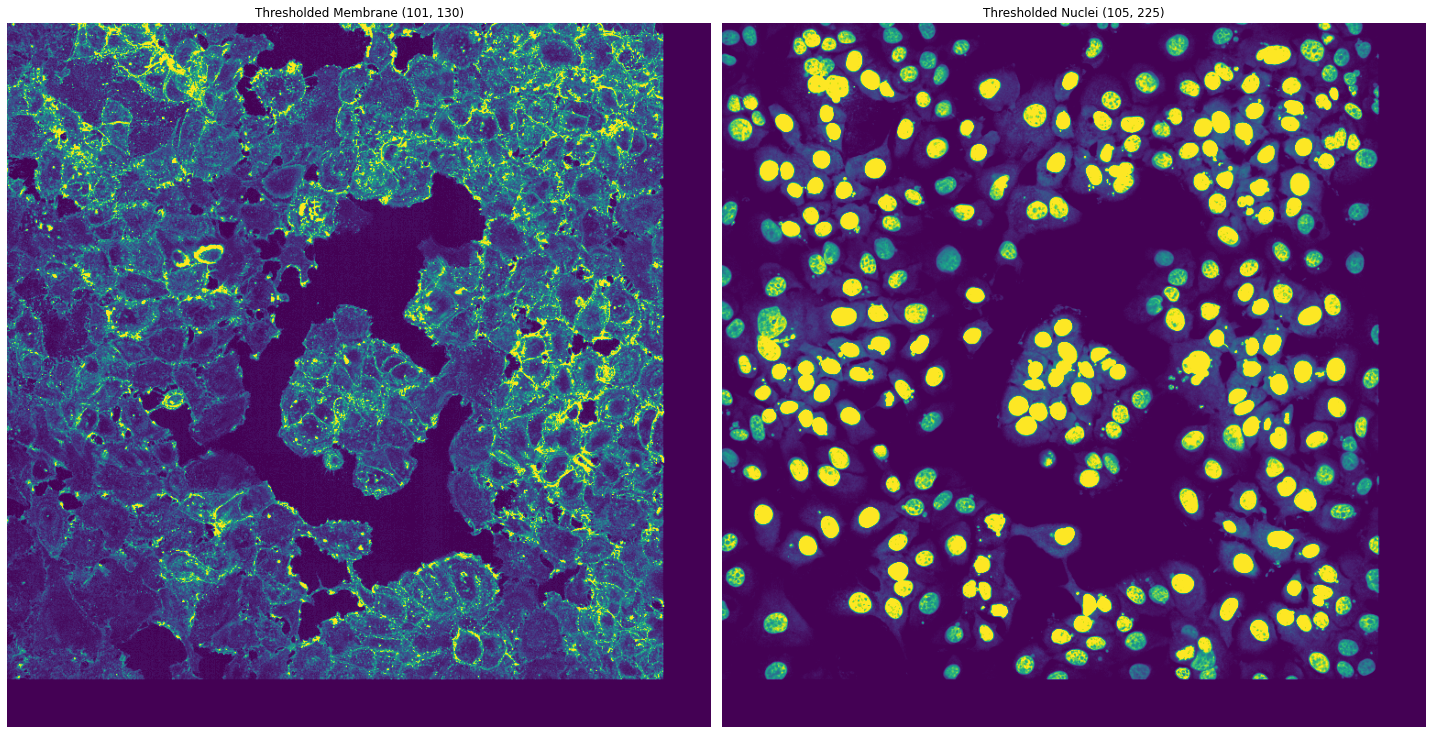

In [139]:
# save plots to a PDF
pp = PdfPages(opdir+"Segmentation-"+runName+"_"+str(mem_p2)+ "_" +str(mem_p98)+ "_" +str(nuc_p2)+ "_" +str(nuc_p98)+ "_" +str(cell_diam)+'-output-images.pdf')
plt.rcParams["figure.figsize"] = (20,20)
f, axarr = plt.subplots(1, 2)  
axarr[0].imshow(mem)
axarr[0].set_title(f"Thresholded Membrane ({mem_p2}, {mem_p98})")
axarr[0].set_axis_off()
axarr[1].imshow(nuc)
axarr[1].set_title(f"Thresholded Nuclei ({nuc_p2}, {nuc_p98})")
axarr[1].set_axis_off()
        
f.tight_layout()
f.savefig(pp, format='pdf')

# 3. Nuclei segmentation & micronuclei quantification

## 3.1 Segment all nuclei

>>>> using CPU
Running test snippet to check if MKL-DNN working
see https://pytorch.org/docs/stable/backends.html?highlight=mkl
** MKL version working - CPU version is sped up. **
processing 1 image(s)
time spent: running network 6.37s; flow+mask computation 1.07
estimated masks for 1 image(s) in 7.46 sec
>>>> TOTAL TIME 7.46 sec


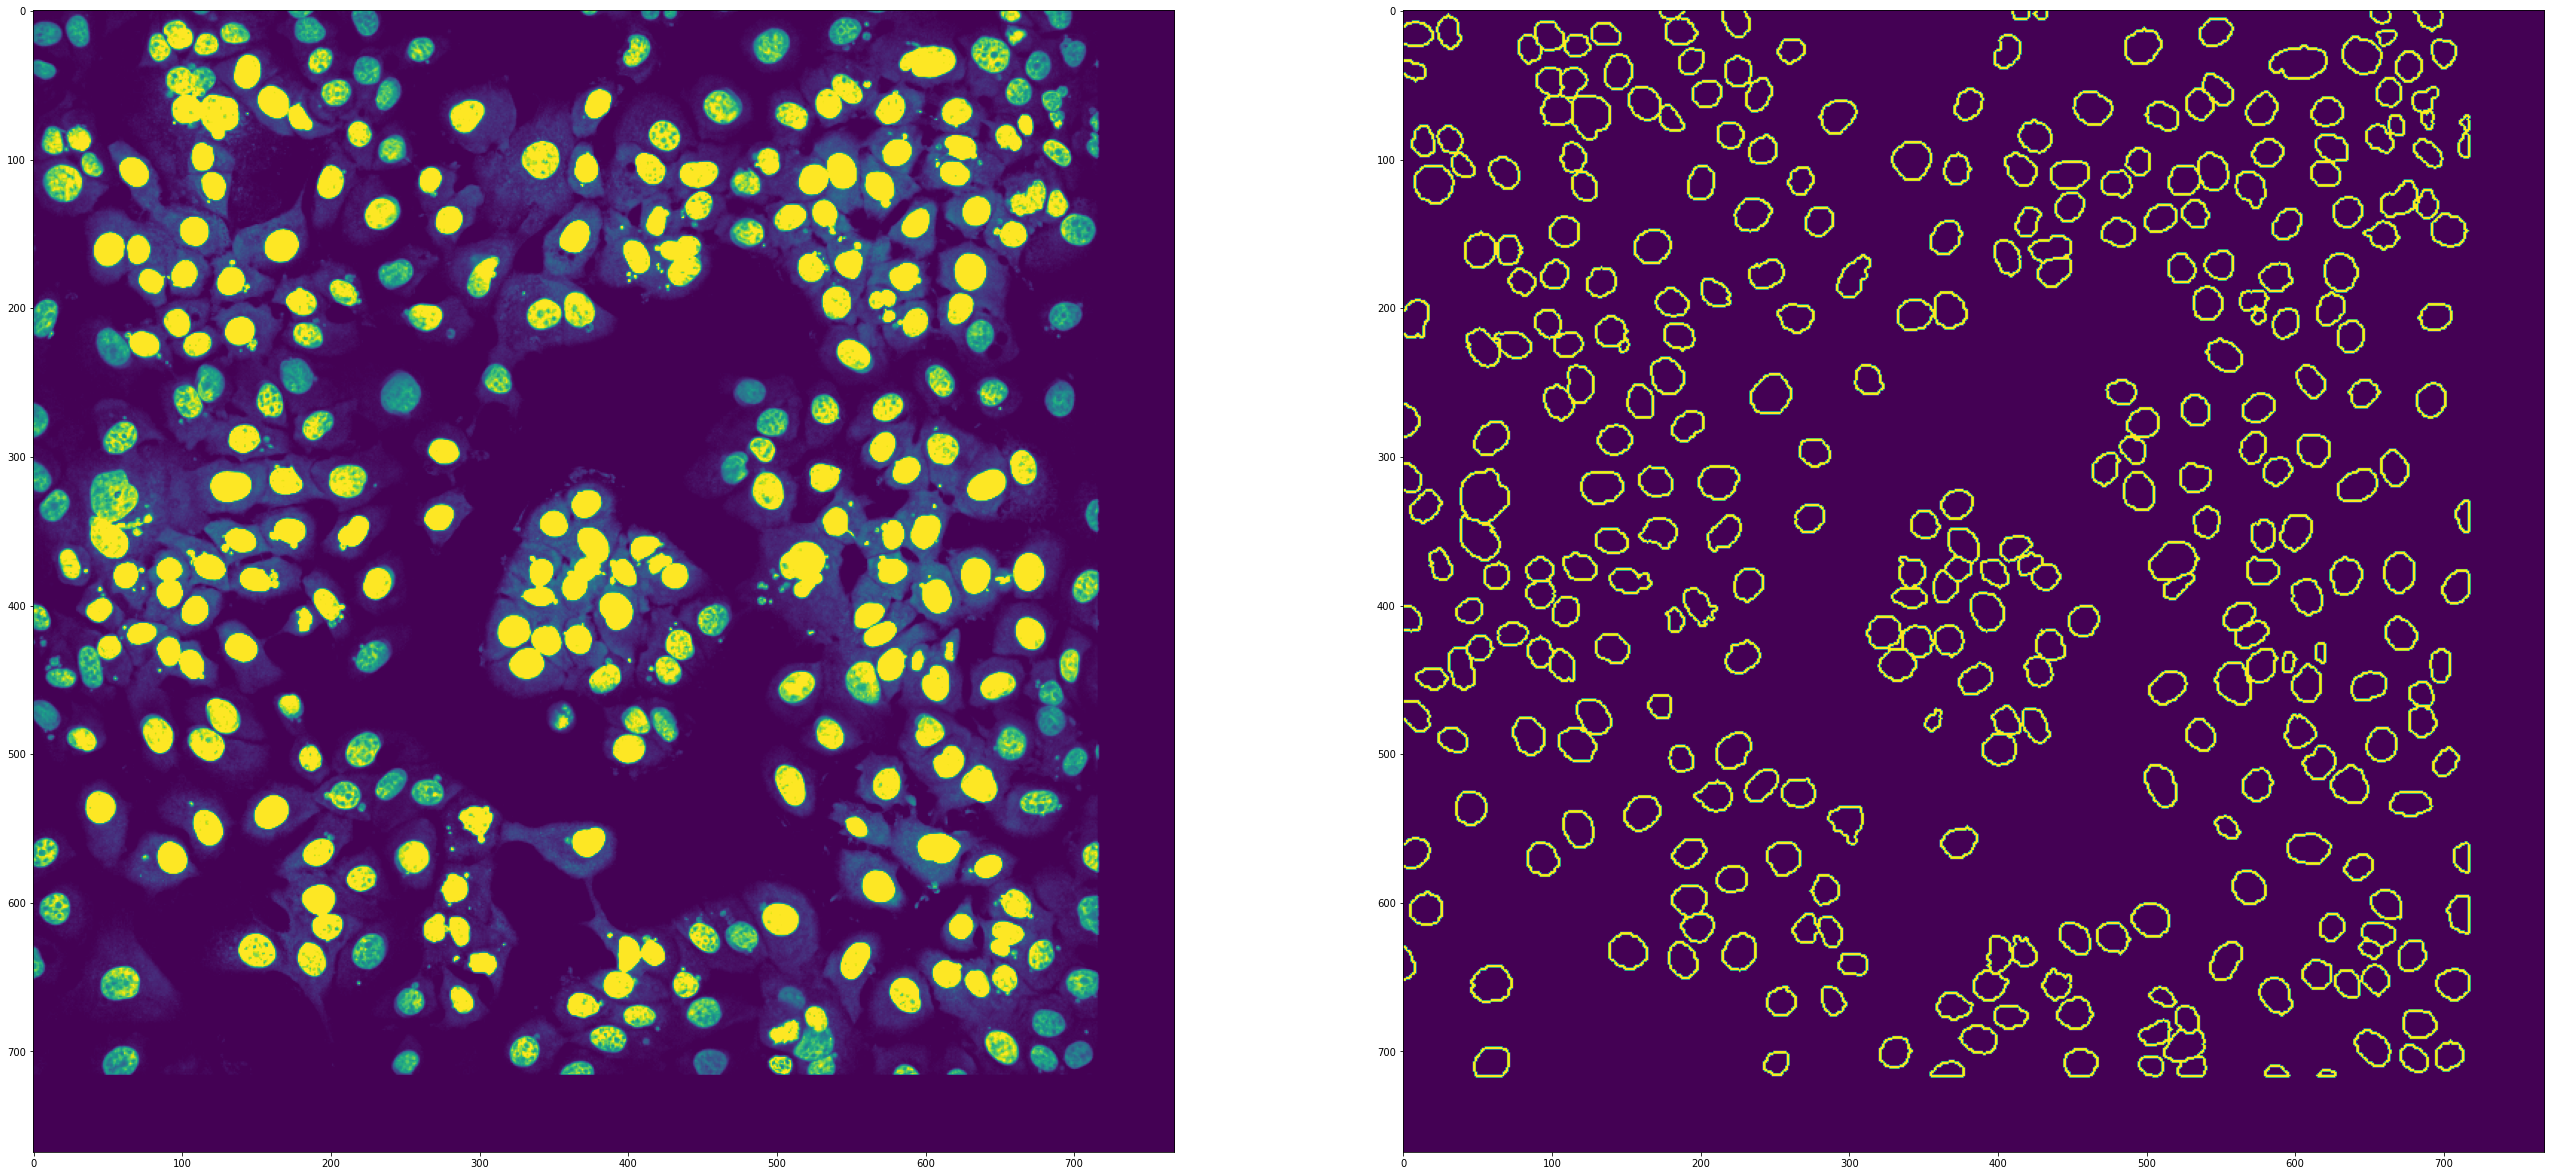

In [140]:
# nuclei segmentation


stack_nuclei = np.stack((nuc, np.zeros(nuc.shape)), axis = 2) #nuc_idx
model = models.Cellpose(gpu=False, model_type='nuclei')
masks_nuc, flows, styles, diams = model.eval(stack_nuclei,
                                             channels=[0,0],
                                             do_3D = False,
                                             diameter = int(25))
fig, ax = plt.subplots(1, 2, figsize=(45, 45))
ax[0].imshow(nuc)
ax[1].imshow(find_boundaries(masks_nuc))

## 3.2 Visualization nuclei size distribution

In [141]:
flat_dapi = nuc.ravel()
flat_nuc = masks_nuc.ravel()

In [142]:
nuc_ids = np.unique(flat_nuc)
nuc_ids = nuc_ids[nuc_ids!=0]
nuc_size = []
for i in range(len(nuc_ids)): 
    nuc_pxls = np.where(flat_nuc==nuc_ids[i])[0]
    nuc_size.append(len(nuc_pxls))
#     if len(nuc_pxls) < nuc_size_thresh:
#         flat_nuc[nuc_pxls]=0
print(len(np.unique(flat_nuc)))

321


Text(0, 0.5, 'Frequency')

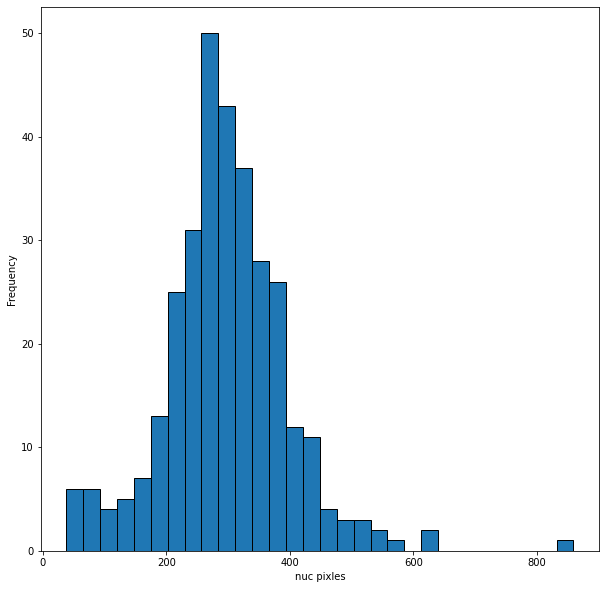

In [143]:
plt.rcParams["figure.figsize"] = (10,10)
plt.hist(nuc_size, bins=30, edgecolor='black')
plt.xlabel('nuc pixles')
plt.ylabel('Frequency')

Nuclei size < 100 are defined to be micronuclei (captured by nuclei segmentation).

## 3.3 Remove segmented nuclei

In [146]:
flat_dapi[flat_nuc>0] = 0

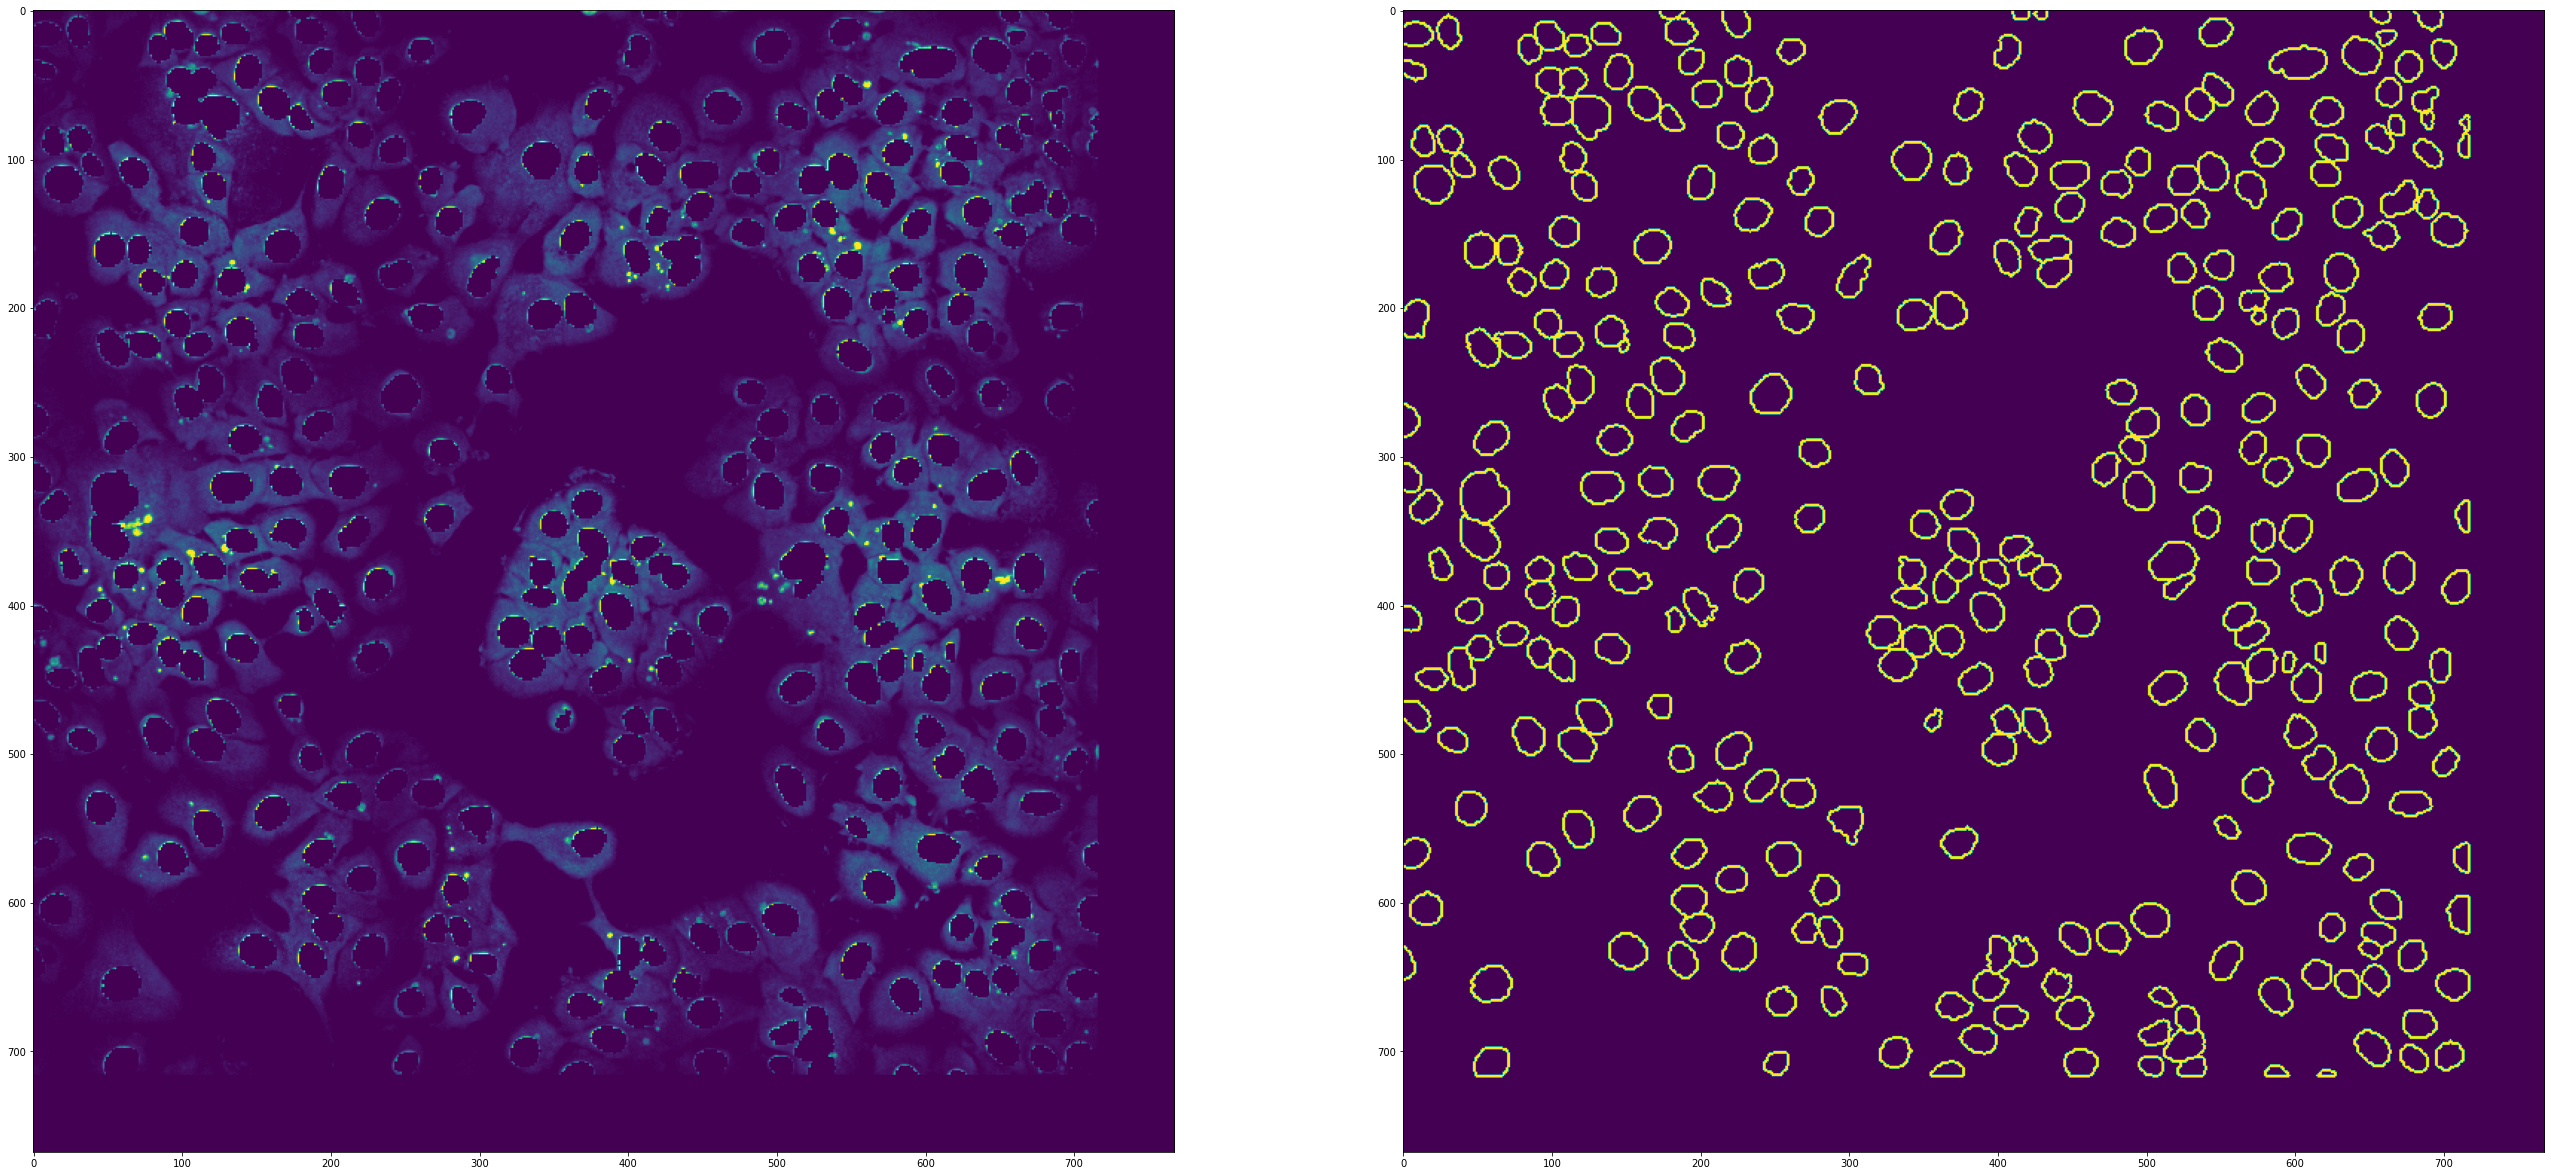

In [147]:
fig, ax = plt.subplots(1, 2, figsize=(45, 45))
ax[0].imshow(nuc)
ax[1].imshow(find_boundaries(masks_nuc))

## 3.4 Remove cytoplamic background

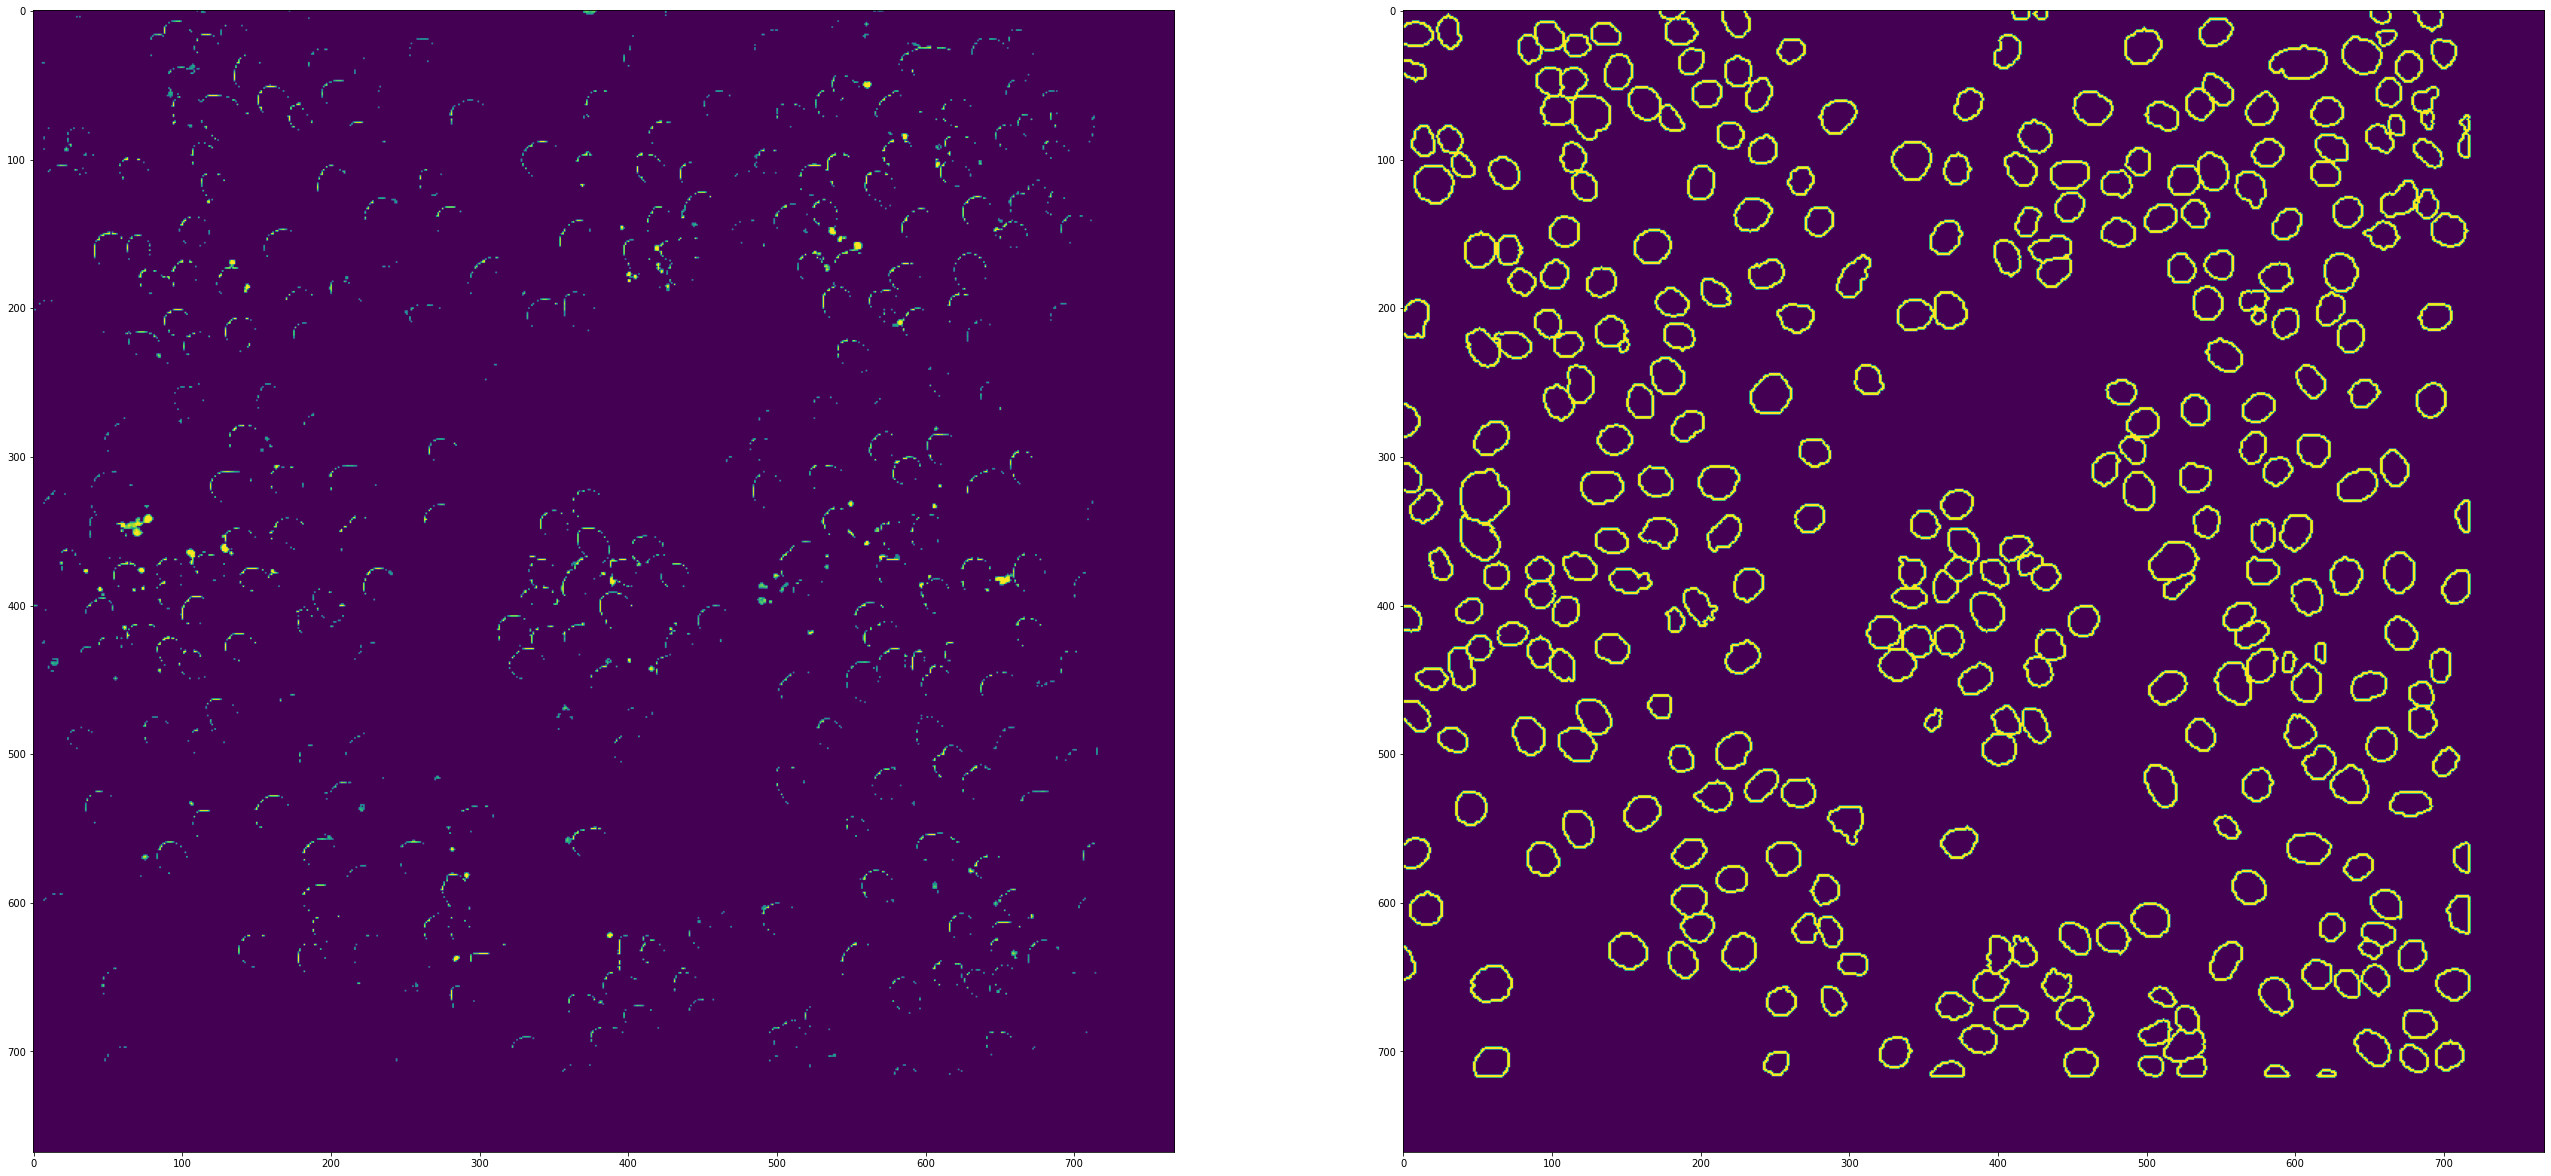

In [148]:
# Remove cytoplamic background
flat_dapi[flat_dapi<=120] = 0

fig, ax = plt.subplots(1, 2, figsize=(45, 45))
ax[0].imshow(nuc)
ax[1].imshow(find_boundaries(masks_nuc))

## 3.5 dialate nuclei masks

In [149]:
# dialate nuc masks by 2 pixel
import cv2
radius=2
outl = find_boundaries(masks_nuc, connectivity=1, mode='thick', background=0)
outl_mask = masks_nuc #Use this for outline with color scheme similar to the cell mask
#Creating a kernel to add pixels of desired size
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
#adding pixels to foreground -- will only work on binary images --- use following command to change thickness
thick_outl = cv2.dilate(outl_mask.astype(np.uint16), kernel, iterations=radius) #Vary iterations parameter for varying thickness 


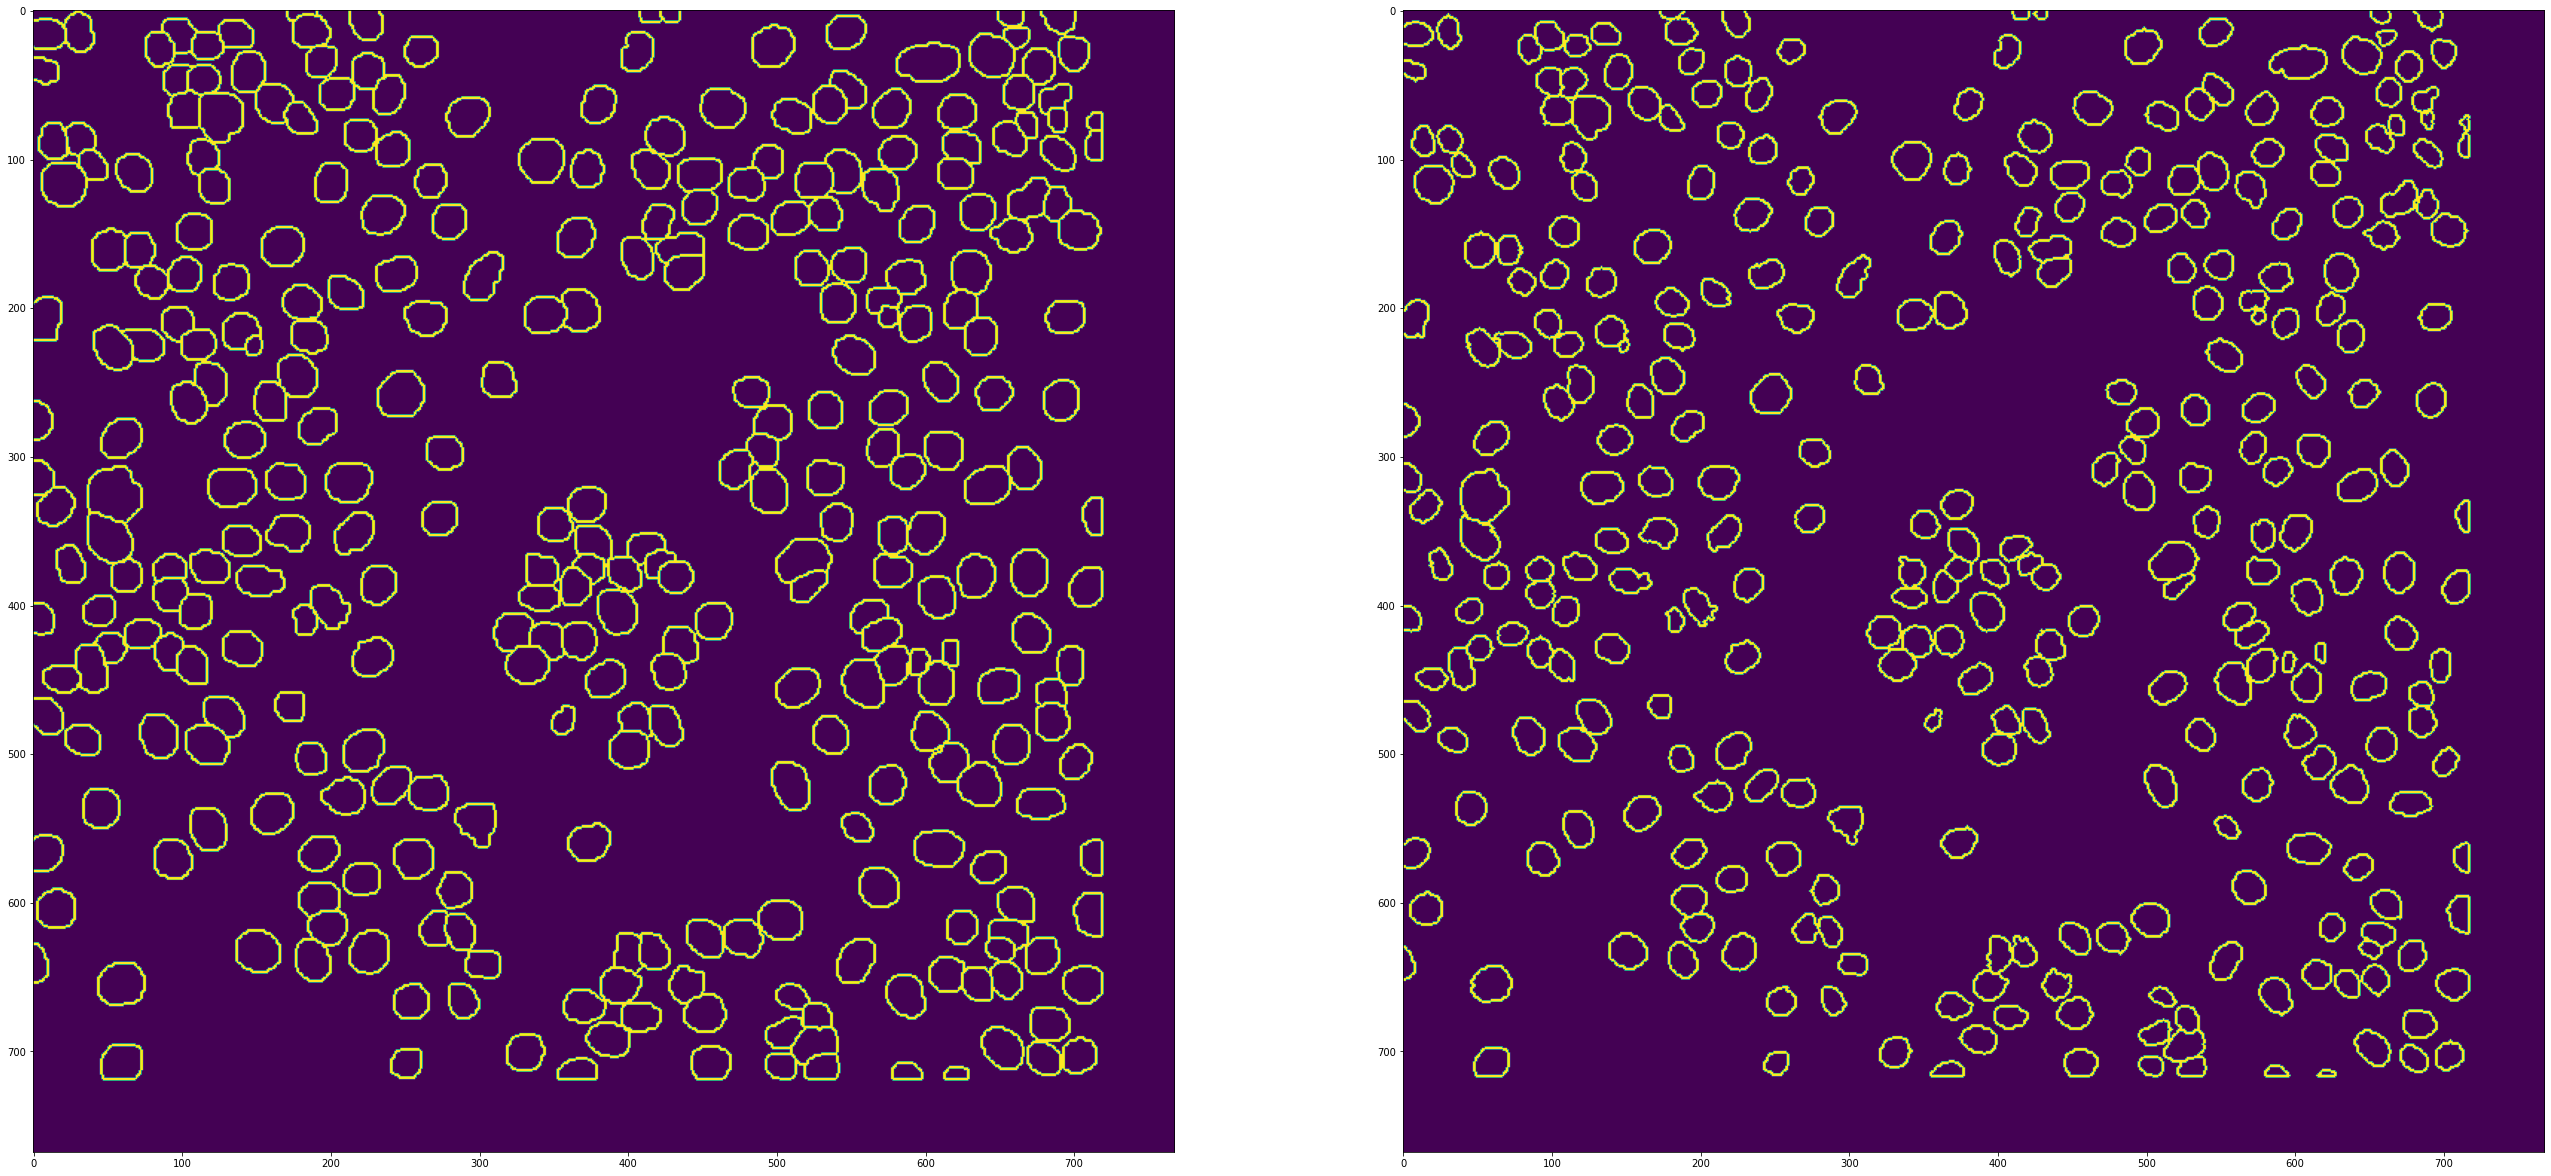

In [150]:
fig, ax = plt.subplots(1, 2, figsize=(45, 45))
ax[0].imshow(find_boundaries(thick_outl))
ax[1].imshow(find_boundaries(masks_nuc))

In [151]:
flat_dapi[thick_outl.ravel()>0] = 0

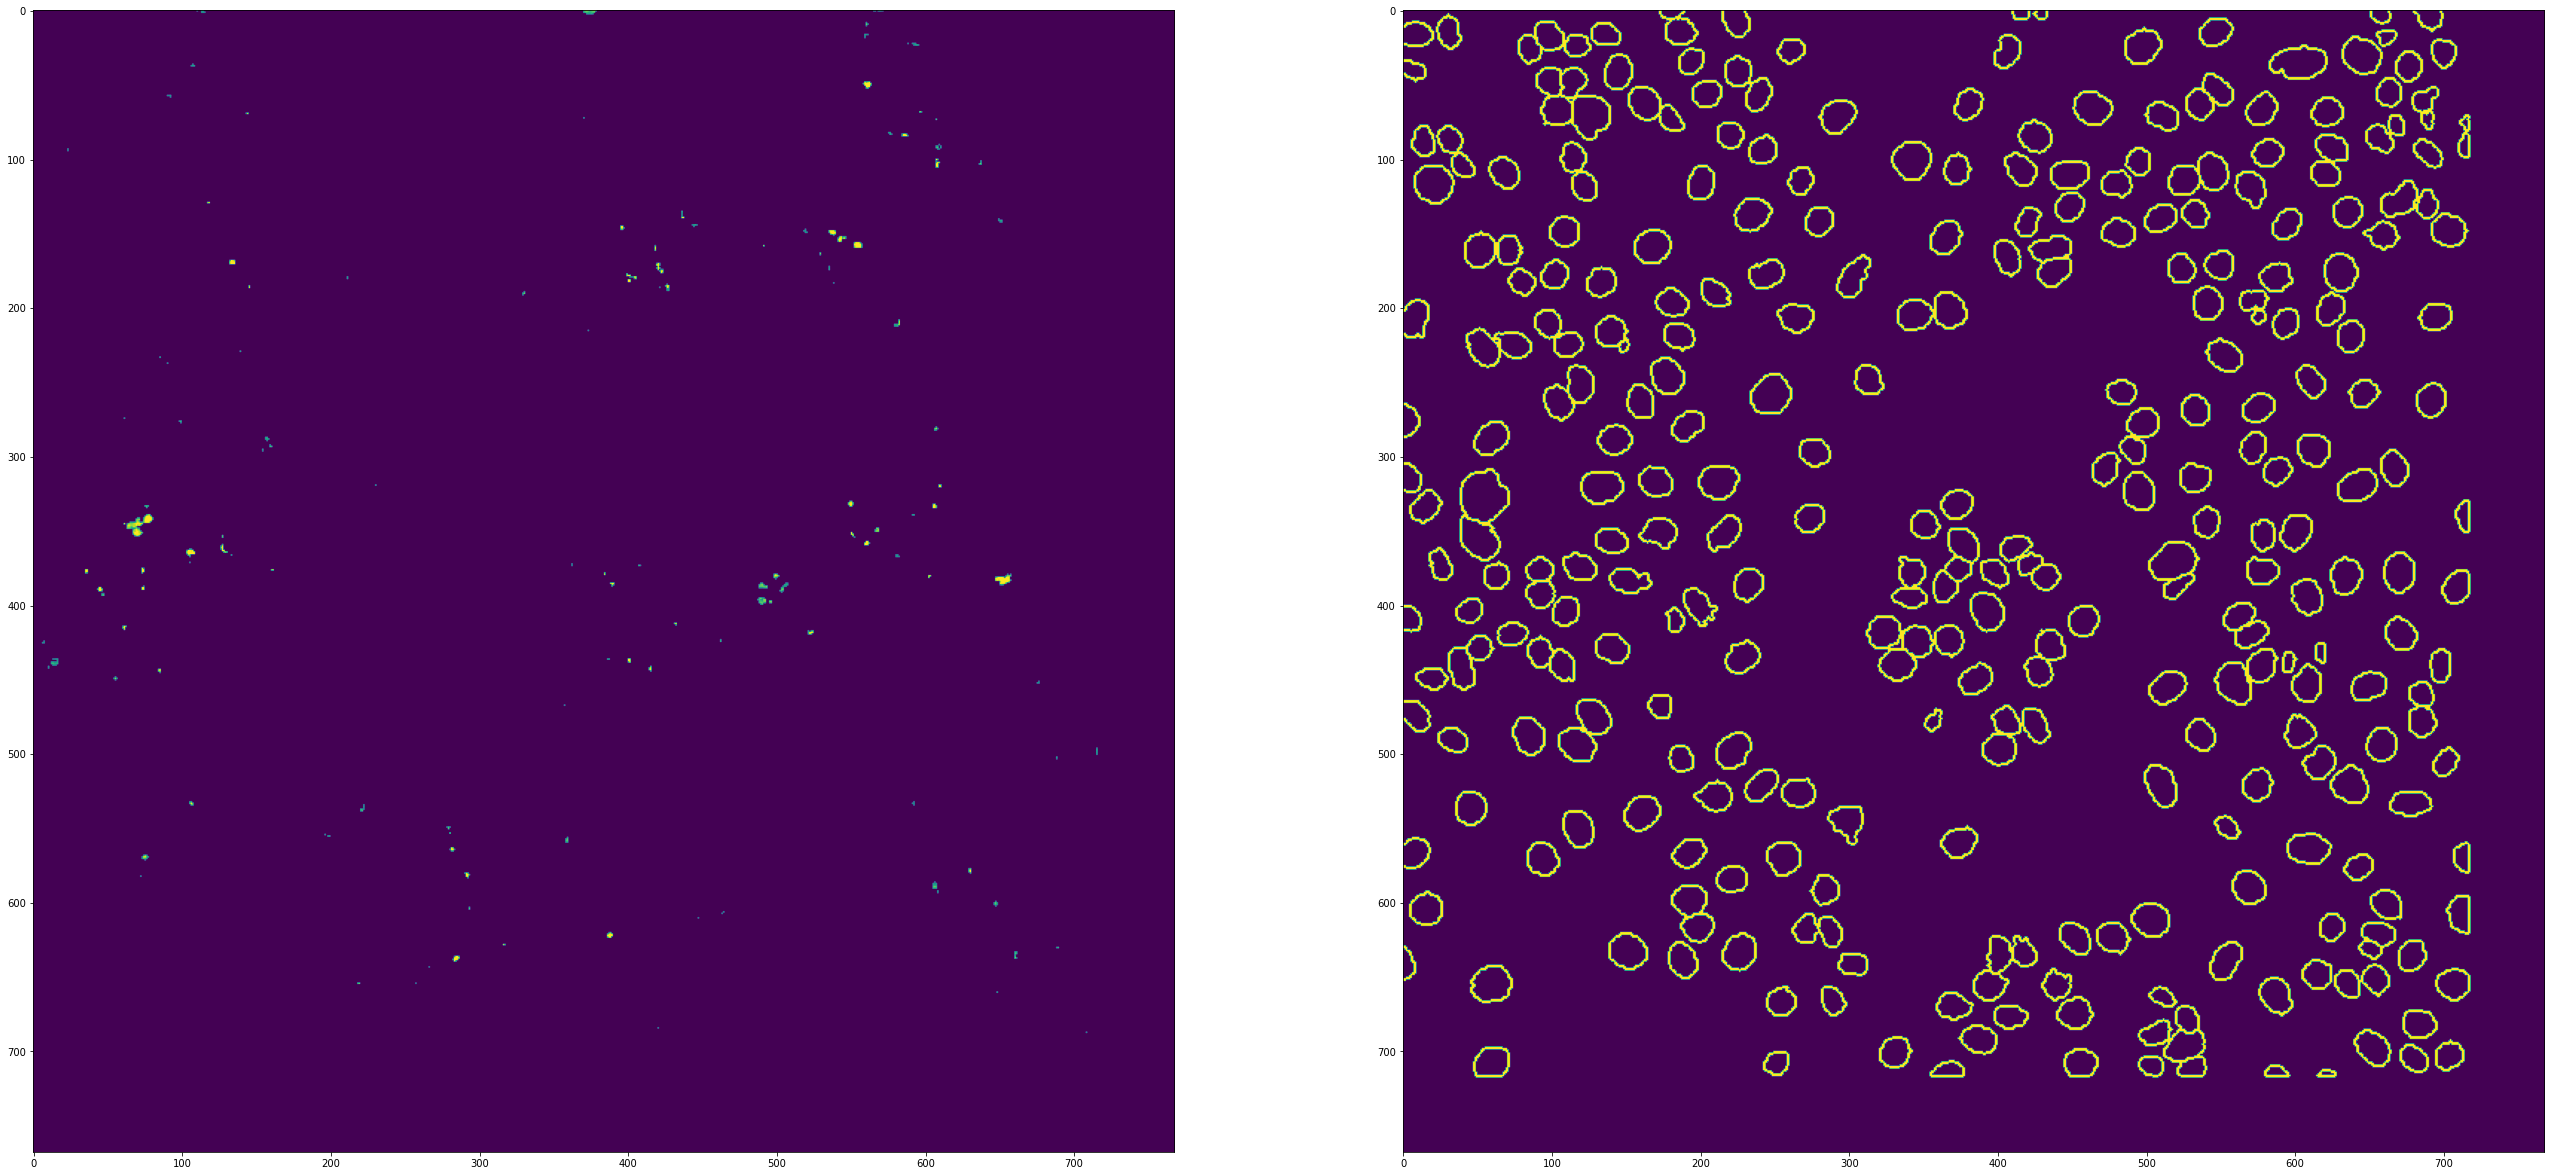

In [152]:
## Visualize the remaining DAPI signal

fig, ax = plt.subplots(1, 2, figsize=(45, 45))
ax[0].imshow(nuc)
ax[1].imshow(find_boundaries(masks_nuc))

## 3.6 Capture micronuclei by spot calling

In [154]:
# Use laplacian of gaussian to detect blobs
spots = spotcall(nuc, min_sig=1, max_sig=5,nsig=5,th=0.5) # Decrease threshold if spots are not identified and min sigma if spots are smaller
spots = np.unique(spots, axis=0)
print("Foci detected:", len(spots))

Foci detected: 144


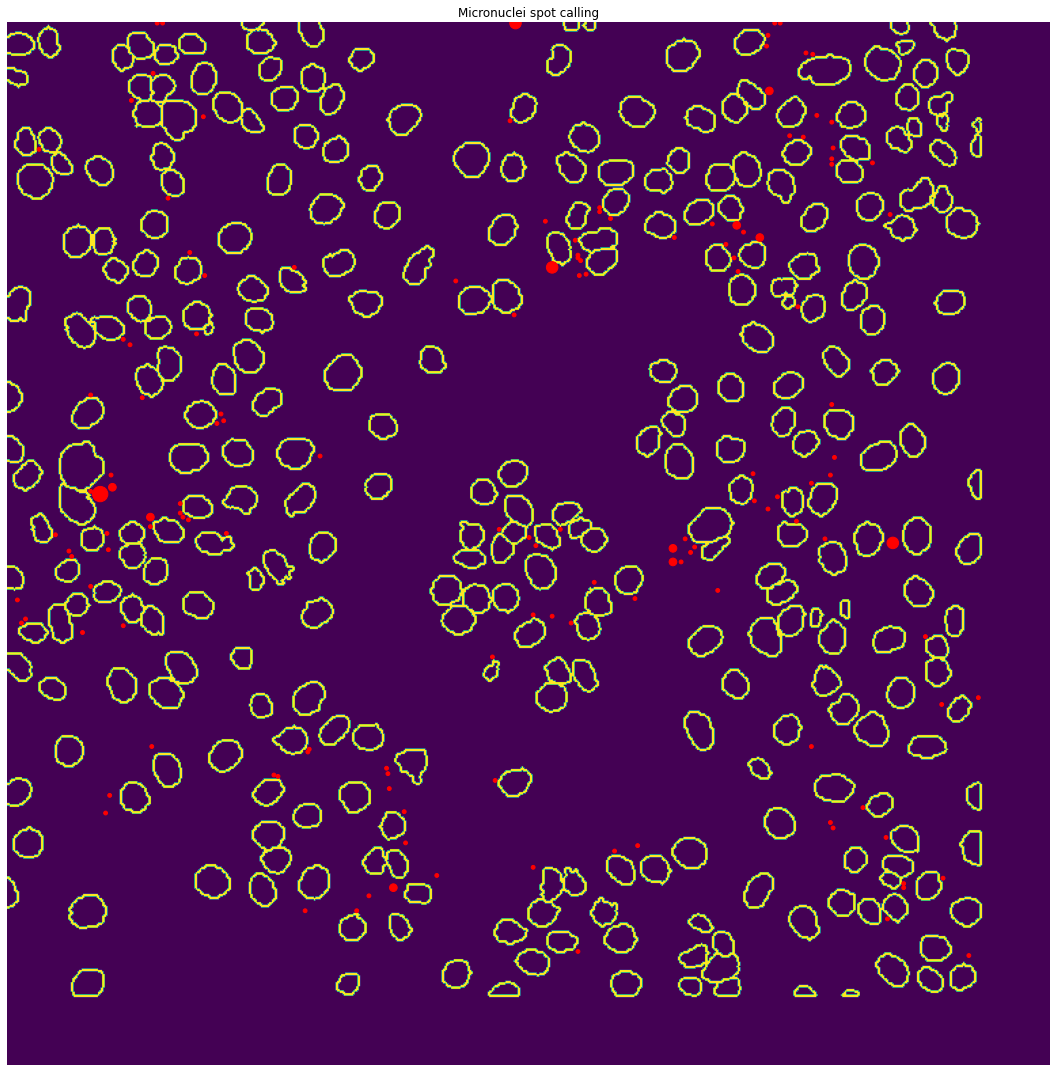

In [155]:
# Visualize micronuclei spots (red)

color = 'red'
title = 'Micronuclei spot calling'
plt.rcParams['figure.figsize'] = [15, 15]
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True)
ax.set_title(title)
ax.imshow(find_boundaries(masks_nuc))
for blob in spots:
    y, x, r = blob
    c = plt.Circle((x, y), r, color=color, linewidth=1, fill=True)
    ax.add_patch(c)
ax.set_axis_off()
plt.tight_layout()
plt.show()

In [ ]:
pp.close()
file2.close()